# Notebook to Investigate LSTM Performance Variance by Huc Type, Includes Forest Cover 

Make sure to import the following packages:  

```bash
# Run this command from within the SnowML directory after cloning the SnowML repo
pip install -y==1.25.0


In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
from snowML.datapipe import snow_types as st
from snowML.datapipe import get_geos as gg
from snowML.datapipe import forest_cover as cover
from snowML.viz import vis_utils as vu
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from itertools import combinations
from scipy.stats import ttest_ind_from_stats
from shapely import wkt

In [2]:
# ignore future warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# initialize erathengine credentials
import ee
ee.Authenticate(auth_mode='notebook')

True

# Step1 - Get MLFlow Metrics

In [4]:
# Upload Metrics + Snow Class Data created by Notebook "LSTM_By_Huc_Download_Metrics"
# These are the metrics for the last epoch (epoch 10) for each huc_id, combined with snow_type data 
f = "single_all_metrics_w_snow_types_and_elev.csv"
df_metrics = pd.read_csv(f)
print(df_metrics.shape)
df_metrics.head(2)

(534, 13)


,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,mean_elevation,Huc_08,Huc_08_nm,geometry,Snow_Type_Color,Test KGE Class,Test KGE color,Elevation Category
0,170103020101,Little North Fork South Fork Coeur d'Alene Riv...,0.002073,0.893745,Montane Forest,1430.934082,17010302,South Fork Coeur d'Alene,"POLYGON ((-115.629450541972 47.47961590993951,...",orange,Good,lightgreen,mid
1,170103020102,Canyon Creek-Upper South Fork Coeur d'Alene River,0.001535,0.936654,Montane Forest,1445.485107,17010302,South Fork Coeur d'Alene,POLYGON ((-115.75460827799712 47.5523761135482...,orange,Excellent,green,mid


In [5]:
#drop huc mostly in Canada that should have been excluded 
df_metrics = df_metrics[df_metrics['HUC_ID'] != 171100050401]

In [6]:
def extract_subdict(original_dict, keys_to_extract):
    return {key: original_dict[key] for key in keys_to_extract if key in original_dict}

In [7]:
# color_map with warm colors 
color_map_snow = {
    "Montane Forest": "darkgreen",  
    "Maritime": "blue",
    "Ephemeral": "#E6E6FA",  # Hex code for lavender
    "Prairie": "lightgreen", 
}


In [8]:
# update the snow colors column with the new colors 
df_metrics['color_snow_type'] = df_metrics['Predominant_Snow'].map(color_map_snow)
df_metrics.head(2)

,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,mean_elevation,Huc_08,Huc_08_nm,geometry,Snow_Type_Color,Test KGE Class,Test KGE color,Elevation Category,color_snow_type
0,170103020101,Little North Fork South Fork Coeur d'Alene Riv...,0.002073,0.893745,Montane Forest,1430.934082,17010302,South Fork Coeur d'Alene,"POLYGON ((-115.629450541972 47.47961590993951,...",orange,Good,lightgreen,mid,darkgreen
1,170103020102,Canyon Creek-Upper South Fork Coeur d'Alene River,0.001535,0.936654,Montane Forest,1445.485107,17010302,South Fork Coeur d'Alene,POLYGON ((-115.75460827799712 47.5523761135482...,orange,Excellent,green,mid,darkgreen


# Step 1A - Add in mean fractional forrest cover

In [9]:
# load forest cover data 
df_forest_cover = cover.load_current_cover_data("Forest_Cover_Percent")
df_forest_cover.rename(columns={"huc_id": "HUC_ID"}, inplace=True)
print(df_forest_cover.shape)
df_forest_cover.head()

(533, 2)


,HUC_ID,Mean Forest Cover
0,170103020101,57.791771
1,170103020102,53.057559
2,170103020103,64.041363
3,170103020201,60.940792
4,170103020202,51.215196


In [10]:
# merge 
df_metrics = pd.merge(df_metrics, df_forest_cover, on="HUC_ID", how="inner")
print(df_metrics.shape)
df_metrics.head()


(533, 15)


,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,mean_elevation,Huc_08,Huc_08_nm,geometry,Snow_Type_Color,Test KGE Class,Test KGE color,Elevation Category,color_snow_type,Mean Forest Cover
0,170103020101,Little North Fork South Fork Coeur d'Alene Riv...,0.002073,0.893745,Montane Forest,1430.934082,17010302,South Fork Coeur d'Alene,"POLYGON ((-115.629450541972 47.47961590993951,...",orange,Good,lightgreen,mid,darkgreen,57.791771
1,170103020102,Canyon Creek-Upper South Fork Coeur d'Alene River,0.001535,0.936654,Montane Forest,1445.485107,17010302,South Fork Coeur d'Alene,POLYGON ((-115.75460827799712 47.5523761135482...,orange,Excellent,green,mid,darkgreen,53.057559
2,170103020103,Placer Creek,0.002172,0.910559,Montane Forest,1343.406860,17010302,South Fork Coeur d'Alene,POLYGON ((-115.91854252267206 47.4535563913611...,orange,Excellent,green,mid,darkgreen,64.041363
3,170103020201,East Fork Pine Creek,0.003249,0.843341,Montane Forest,1246.835693,17010302,South Fork Coeur d'Alene,POLYGON ((-116.19050663866074 47.4981031484545...,orange,Good,lightgreen,mid,darkgreen,60.940792
4,170103020202,West Fork Pine Creek-Pine Creek,0.001211,0.853109,Montane Forest,1175.266357,17010302,South Fork Coeur d'Alene,POLYGON ((-116.19050663866074 47.4981031484545...,orange,Good,lightgreen,mid,darkgreen,51.215196


# Step 2 - Define Plotting And Analytics Functions 

Moved to snowML.viz vis_utils module



# Step 3 Create ScatterPlots

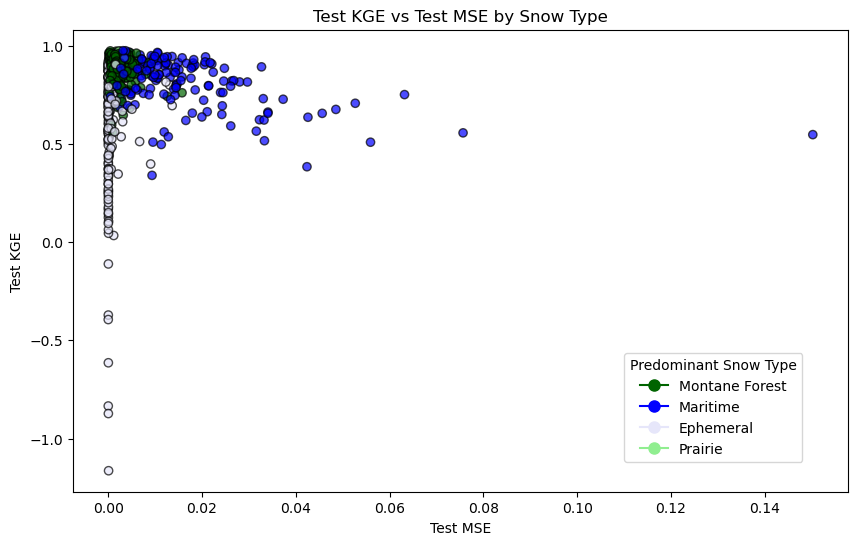

In [11]:
# All results 
y_var = "Test KGE"
x_var = "Test MSE"
ttl = f"{y_var}_vs_{x_var}_by_Snow_Type"
vu.plot_scatter(df_metrics, "Test MSE", "Test KGE", color_map_snow, title = ttl)

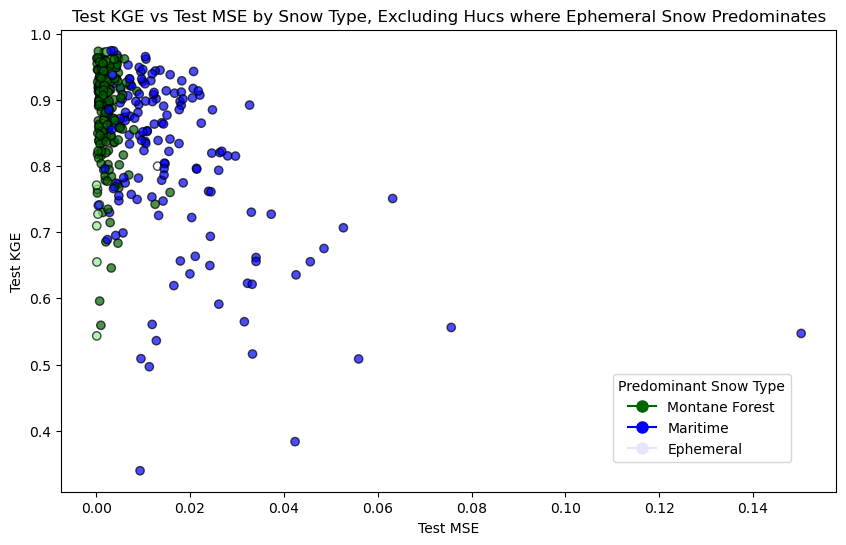

In [12]:
# Results with Ephemeral Removed 
df_noE = df_metrics[df_metrics["Predominant_Snow"] != "Ephemeral"]
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
y_var = "Test KGE"
x_var = "Test MSE"
ttl = f"{y_var}_vs_{x_var}_by_Snow_Type, Excluding Hucs where Ephemeral Snow Predominates"
vu.plot_scatter(df_noE, "Test MSE", "Test KGE", color_map, title = ttl)

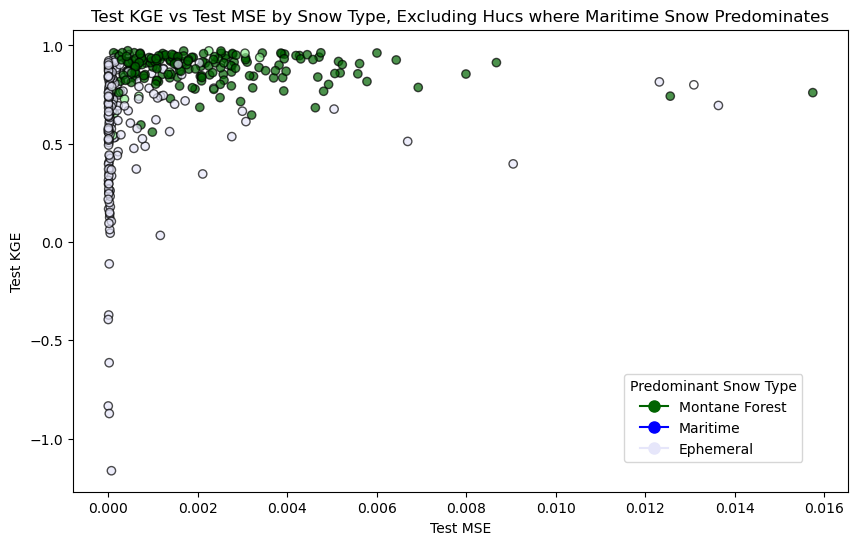

In [13]:
# Results with Maritime Removed 
df_noMar = df_metrics[df_metrics["Predominant_Snow"] != "Maritime"]
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
y_var = "Test KGE"
x_var = "Test MSE"
ttl = f"{y_var}_vs_{x_var}_by_Snow_Type, Excluding Hucs where Maritime Snow Predominates"
vu.plot_scatter(df_noMar, "Test MSE", "Test KGE", color_map, title = ttl)

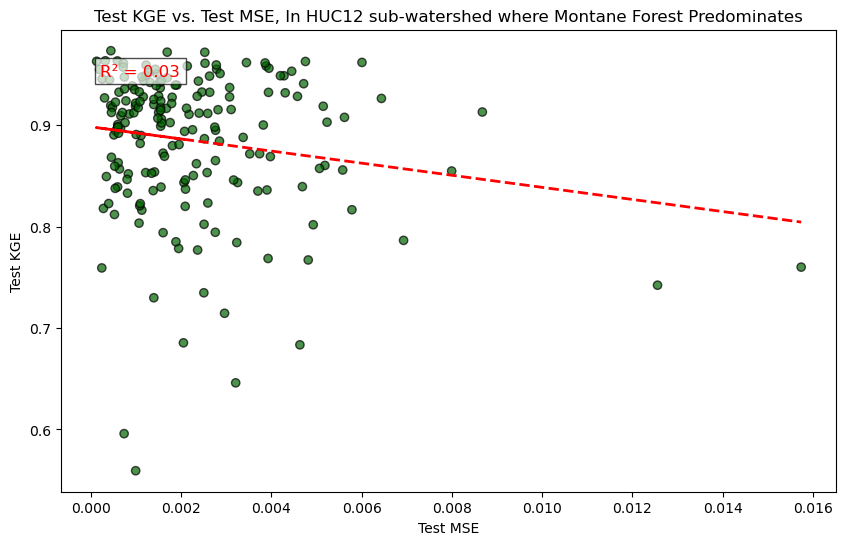

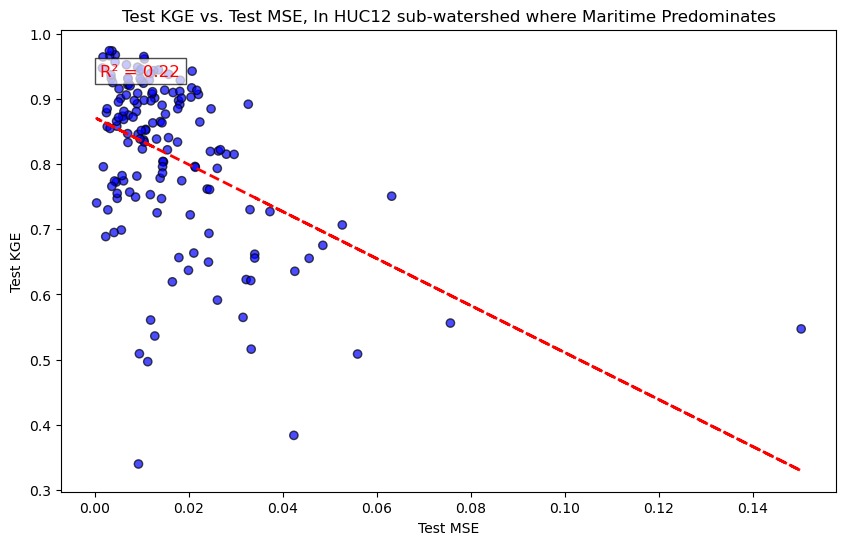

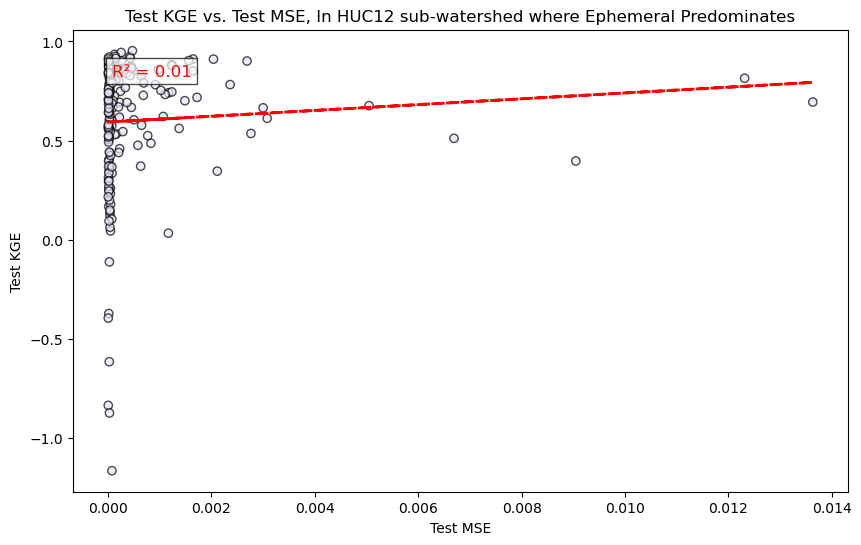

In [14]:
# Scatterlot by snowtype 

for snowtype in color_map.keys():
    df_st = df_metrics[df_metrics["Predominant_Snow"] == snowtype]
    #print(df_st.head(2))
    ttl = f"Test KGE vs. Test MSE, In HUC12 sub-watershed where {snowtype} Predominates"
    vu.plot_scatter_w_R2(df_st, "Test MSE", "Test KGE", color_map_snow, title = ttl, show_legend = False)

# NOTE THAT EACH PLOT HAS A DIFFERENT SCALE IN ORDER TO VISUALIZE DIFFERENCES WITHIN SNOWCLASS 
# BUT CAREFUL RE COMPARING ACCROSS SNOWTYPES USING THE BELOW
    

# Step 4 - Create box and whisker plot by Snow Type; Run T-Tests

In [15]:
# Exclude Prarie and Boreal sub, hucs.  Optionally exclude Ephemeral 
snow_types_to_include = ["Montane Forest", "Ephemeral", "Maritime"]
filtered_df = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]

snow_types_to_include = ["Montane Forest", "Maritime"]
filtered_df_MandM = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]



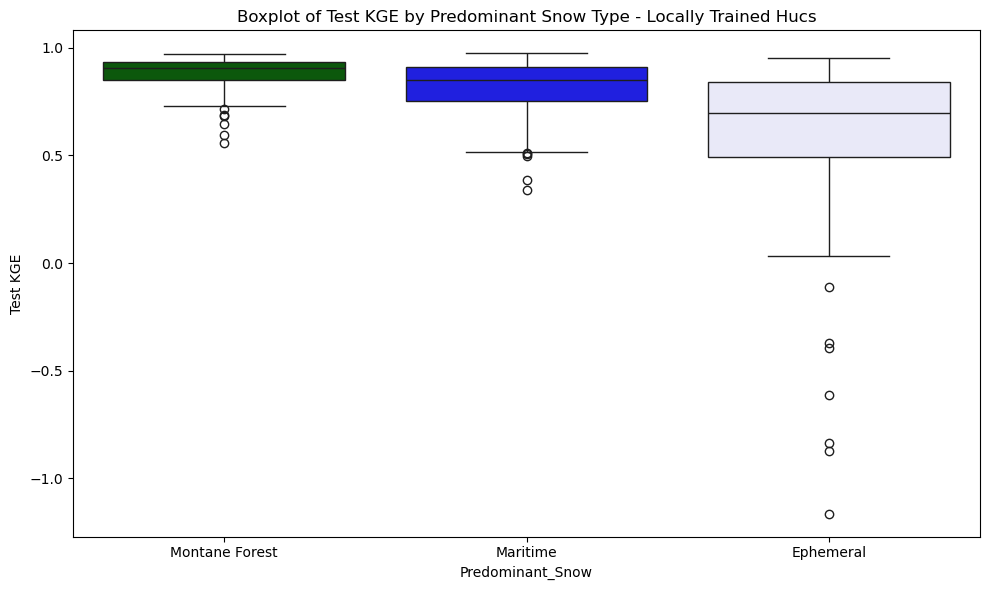

,count,median,mean,std
Predominant_Snow,,,,
Ephemeral,180,0.697708,0.602179,0.342374
Maritime,154,0.851797,0.813383,0.127179
Montane Forest,187,0.905873,0.884662,0.070911


In [16]:
parameter = "Test KGE"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs"
group_by = "Predominant_Snow"
grouped_data = vu.plot_boxplot_by_group(filtered_df, parameter, ttl, group_by, color_map = color_map)
grouped_data


In [17]:
p_values = vu.pairwise_welch_t_test(grouped_data)
p_values

,Group1,Group2,P-Value
0,Ephemeral,Maritime,4.304679e-13
1,Ephemeral,Montane Forest,9.953465e-22
2,Maritime,Montane Forest,2.521648e-09


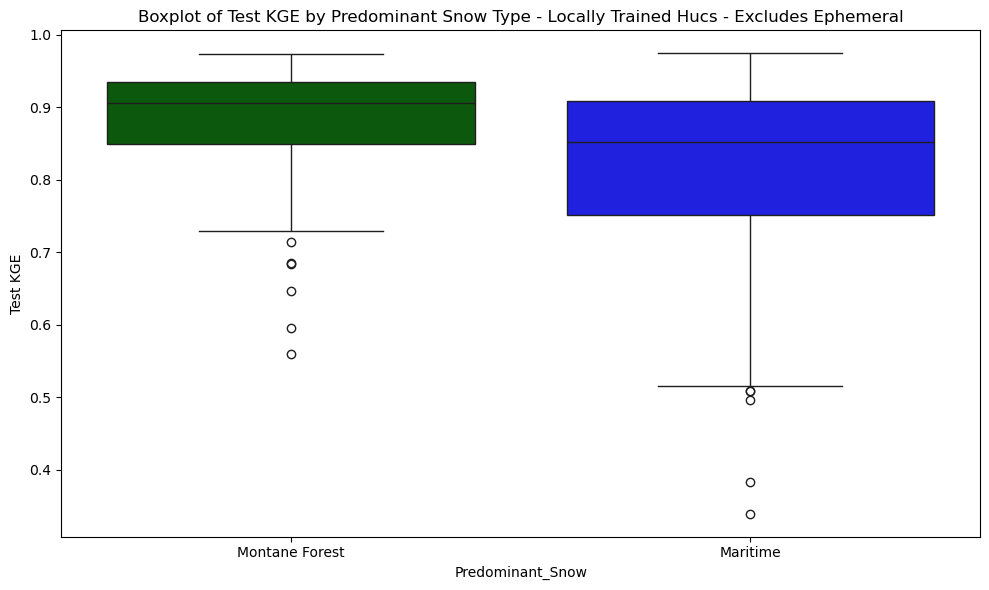

,count,median,mean,std
Predominant_Snow,,,,
Maritime,154,0.851797,0.813383,0.127179
Montane Forest,187,0.905873,0.884662,0.070911


In [18]:
parameter = "Test KGE"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime"])
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs - Excludes Ephemeral"
group_by = "Predominant_Snow"
grouped_data = vu.plot_boxplot_by_group(filtered_df_MandM, parameter, ttl, group_by, color_map = color_map)
grouped_data 

In [19]:
p_values = vu.pairwise_welch_t_test(grouped_data)
p_values

,Group1,Group2,P-Value
0,Maritime,Montane Forest,2.521648e-09


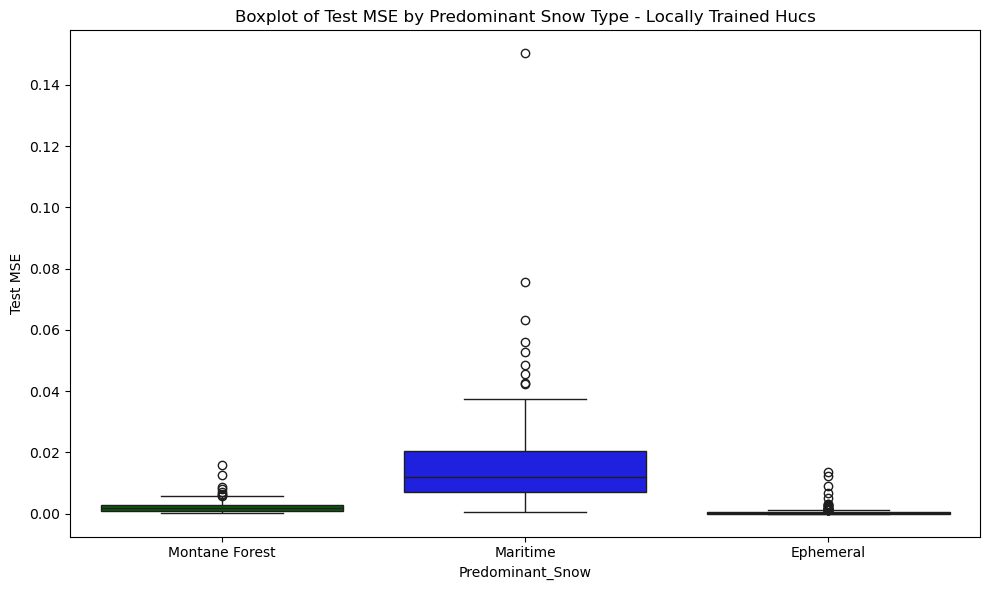

,count,median,mean,std
Predominant_Snow,,,,
Ephemeral,180,0.000052,0.000577,0.001691
Maritime,154,0.011931,0.016126,0.016521
Montane Forest,187,0.001671,0.002268,0.002026


In [20]:
parameter = "Test MSE"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs"
group_by = "Predominant_Snow"
grouped_data = vu.plot_boxplot_by_group(filtered_df, parameter, ttl, group_by, color_map = color_map)
grouped_data

In [21]:
p_values = vu.pairwise_welch_t_test(grouped_data)
p_values

,Group1,Group2,P-Value
0,Ephemeral,Maritime,6.810076e-23
1,Ephemeral,Montane Forest,1.279809e-16
2,Maritime,Montane Forest,1.899657e-19


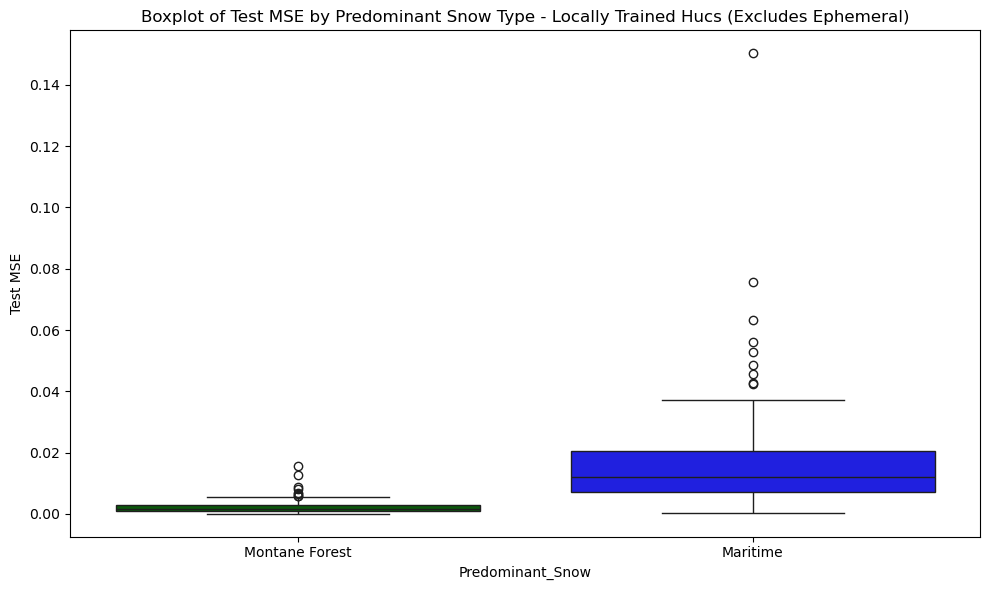

,count,median,mean,std
Predominant_Snow,,,,
Maritime,154,0.011931,0.016126,0.016521
Montane Forest,187,0.001671,0.002268,0.002026


In [22]:

parameter = "Test MSE"
ttl = f"Boxplot of {parameter} by Predominant Snow Type - Locally Trained Hucs (Excludes Ephemeral)"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime"])
group_by = "Predominant_Snow"
grouped_data = vu.plot_boxplot_by_group(filtered_df_MandM, parameter, ttl, group_by, color_map = color_map)
grouped_data

In [23]:
p_values = vu.pairwise_welch_t_test(grouped_data)
p_values

,Group1,Group2,P-Value
0,Maritime,Montane Forest,1.899657e-19


# Step 5 Examine by Basin

In [24]:
# sort by the median KGE for the basin, when excluding ephemeral watersheds 
aggregated_df_KGE = (
    filtered_df_MandM.groupby("Huc_08_nm", as_index=False)["Test KGE"]
    .median()
    .sort_values(by="Test KGE", ascending=False)
)
aggregated_df_KGE.head(2)


,Huc_08_nm,Test KGE
8,South Fork Salmon,0.926219
3,Middle Salmon-Chamberlain,0.912381


In [25]:
basin_sort_order = list(aggregated_df_KGE["Huc_08_nm"])
#basin_sort_order

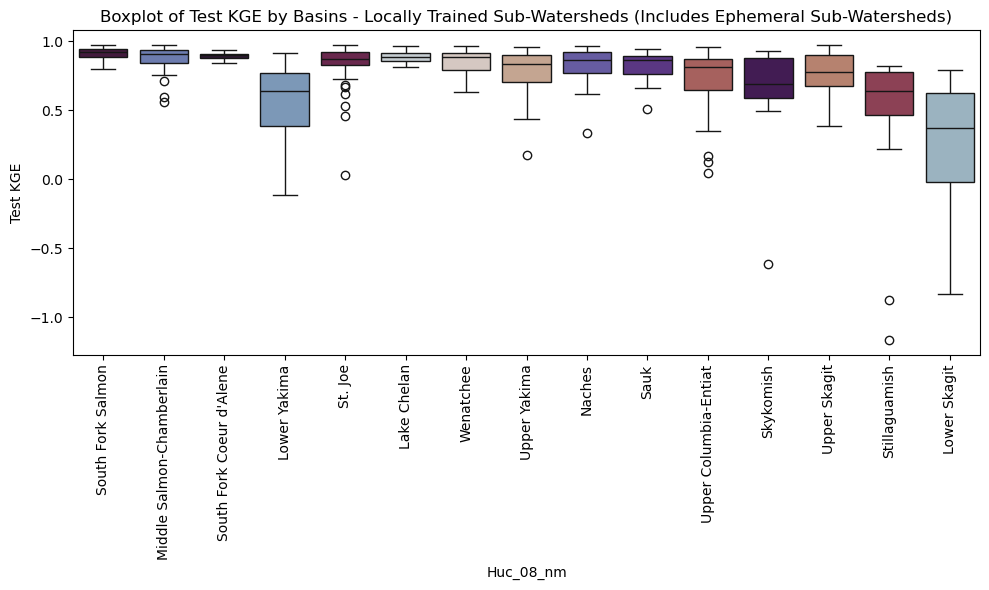

,count,median,mean,std
Huc_08_nm,,,,
Lake Chelan,28,0.890976,0.887545,0.043415
Lower Skagit,11,0.371368,0.239156,0.534200
Lower Yakima,71,0.641896,0.581521,0.256215
Middle Salmon-Chamberlain,51,0.912341,0.880008,0.085800
Naches,29,0.863231,0.830452,0.128844
Sauk,15,0.863420,0.815425,0.116398
Skykomish,21,0.693638,0.663461,0.326345
South Fork Coeur d'Alene,8,0.905497,0.895503,0.031835
South Fork Salmon,41,0.926219,0.913418,0.041302


In [26]:
parameter = "Test KGE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Locally Trained Sub-Watersheds (Includes Ephemeral Sub-Watersheds)"
vu.plot_boxplot_by_group(filtered_df, parameter, ttl, groupby, category_order = basin_sort_order, trunc = True)

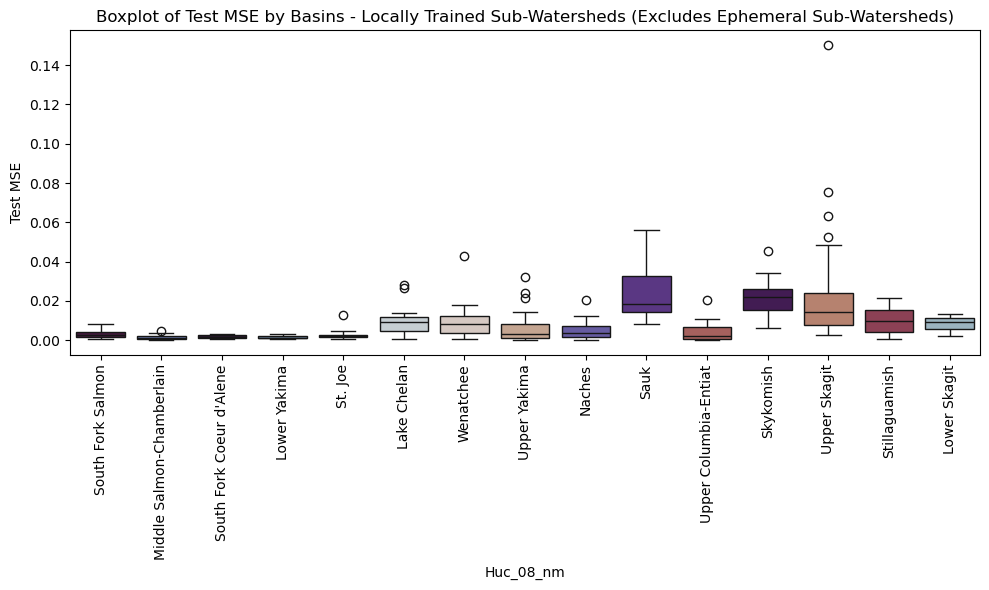

,count,median,mean,std
Huc_08_nm,,,,
Lake Chelan,23,0.009067,0.009144,0.007057
Lower Skagit,3,0.009338,0.008168,0.005802
Lower Yakima,4,0.001256,0.001583,0.001169
Middle Salmon-Chamberlain,50,0.001089,0.001424,0.001016
Naches,23,0.003860,0.004961,0.004690
Sauk,15,0.018488,0.023697,0.013218
Skykomish,15,0.021745,0.022191,0.010362
South Fork Coeur d'Alene,8,0.001804,0.001848,0.000984
South Fork Salmon,41,0.002847,0.003179,0.001711


In [27]:
parameter = "Test MSE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Locally Trained Sub-Watersheds (Excludes Ephemeral Sub-Watersheds)"
vu.plot_boxplot_by_group(filtered_df_MandM, parameter, ttl, groupby, category_order = basin_sort_order, trunc = True)

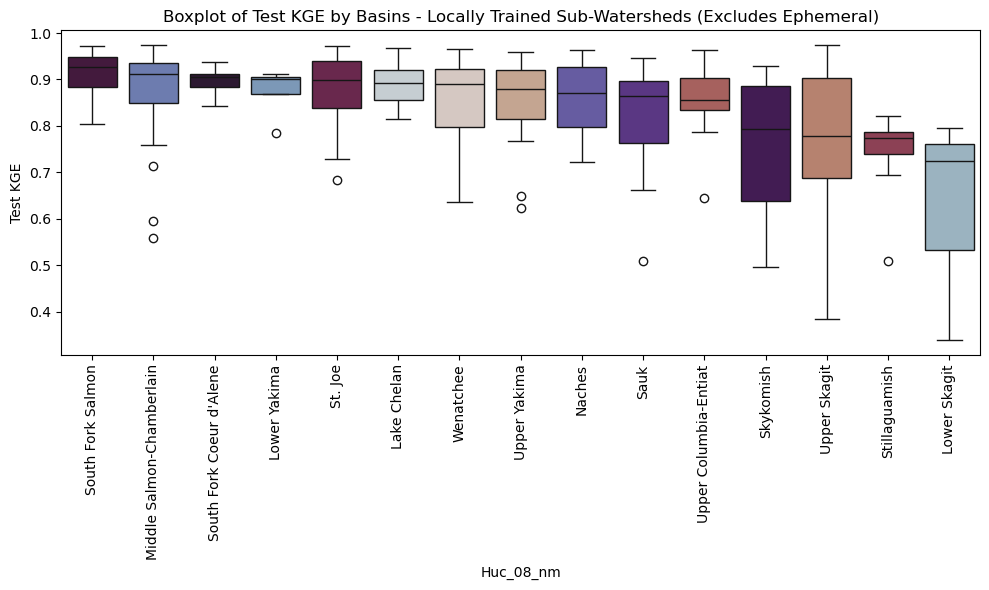

,count,median,mean,std
Huc_08_nm,,,,
Lake Chelan,23,0.892614,0.887429,0.046952
Lower Skagit,3,0.725214,0.620256,0.245563
Lower Yakima,4,0.900001,0.874058,0.060208
Middle Salmon-Chamberlain,50,0.912381,0.881787,0.085716
Naches,23,0.871688,0.863690,0.076113
Sauk,15,0.863420,0.815425,0.116398
Skykomish,15,0.793439,0.753656,0.152286
South Fork Coeur d'Alene,8,0.905497,0.895503,0.031835
South Fork Salmon,41,0.926219,0.913418,0.041302


In [28]:
parameter = "Test KGE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Locally Trained Sub-Watersheds (Excludes Ephemeral)"
vu.plot_boxplot_by_group(filtered_df_MandM, parameter, ttl, groupby, category_order = basin_sort_order, trunc = True)

# Step  6 - Examine by Forest Cover

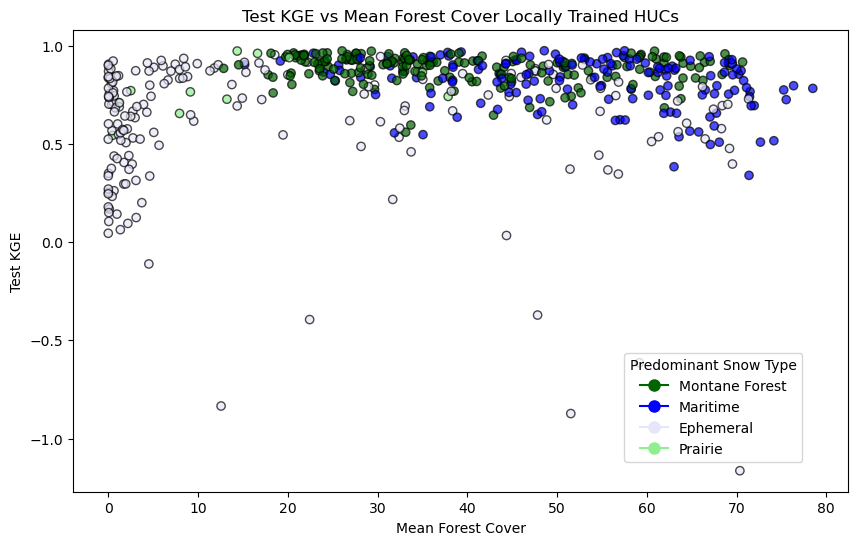

In [29]:
x_var_name = "Mean Forest Cover"
y_var_name = "Test KGE"
ttl = f"{y_var_name}_vs_{x_var_name}_Locally Trained HUCs"
vu.plot_scatter(df_metrics, x_var_name, y_var_name, color_map_snow, title = ttl)

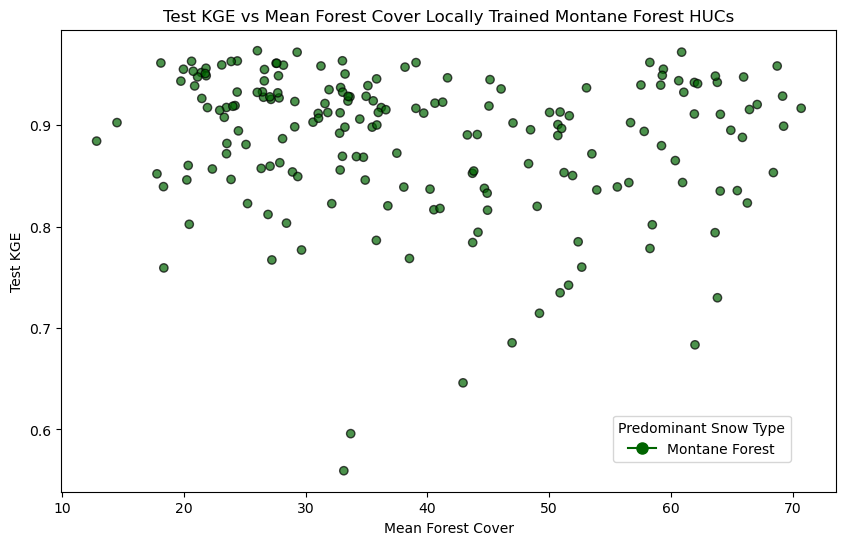

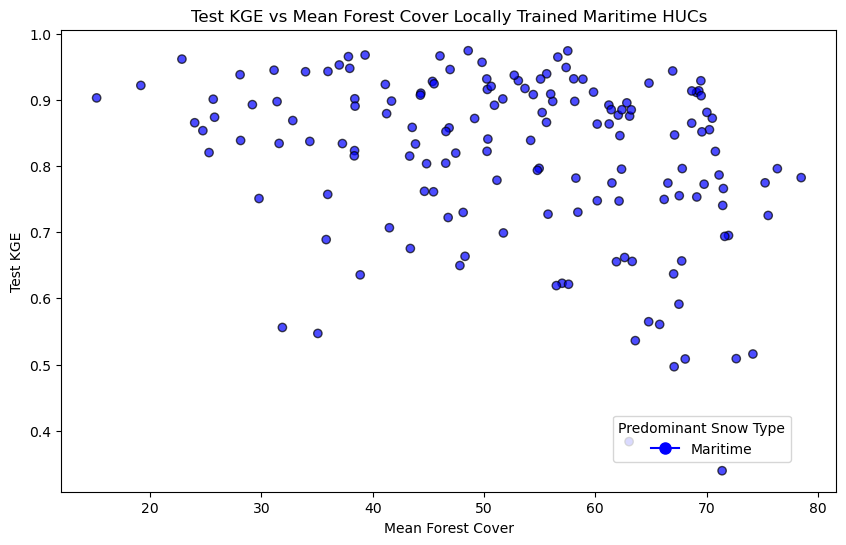

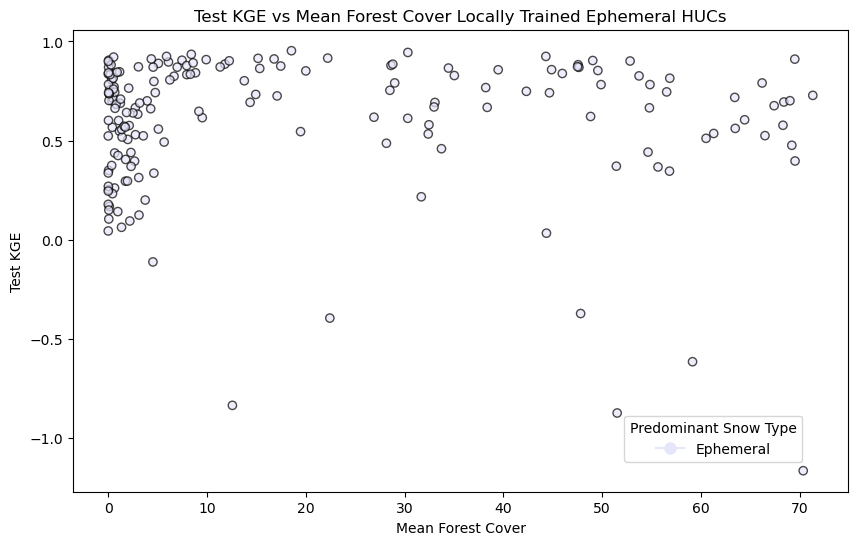

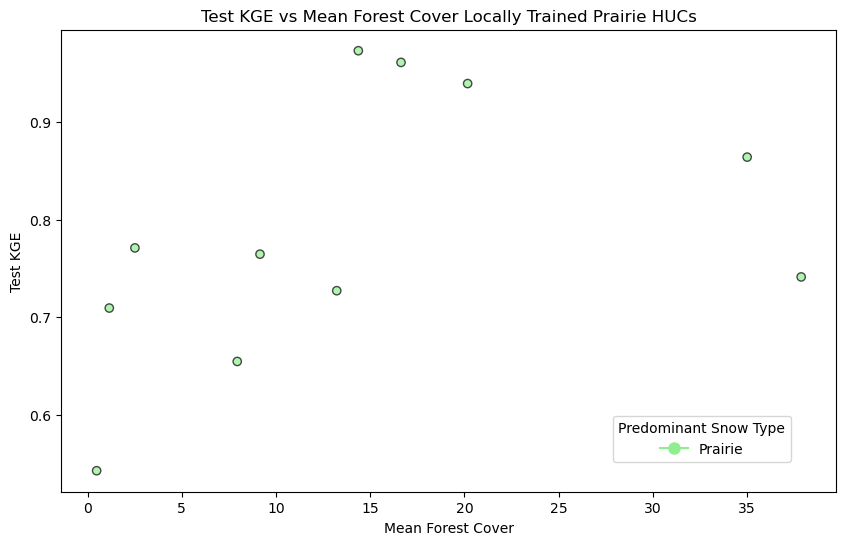

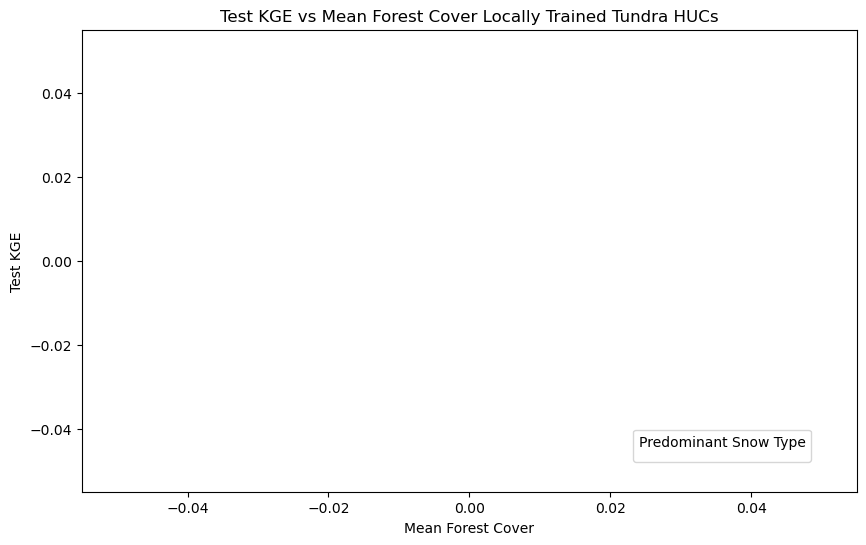

In [30]:
x_var_name = "Mean Forest Cover"
y_var_name = "Test KGE"

for snow_type in ["Montane Forest", "Maritime", "Ephemeral", "Prairie", "Tundra"]: 
    ttl = f"{y_var_name}_vs_{x_var_name}_Locally_Trained_{snow_type}_HUCs"
    color_map = extract_subdict(color_map_snow, [snow_type])
    single_snow_df = df_metrics[df_metrics["Predominant_Snow"] == snow_type]
    vu.plot_scatter(single_snow_df, x_var_name, y_var_name, color_map, title = ttl)

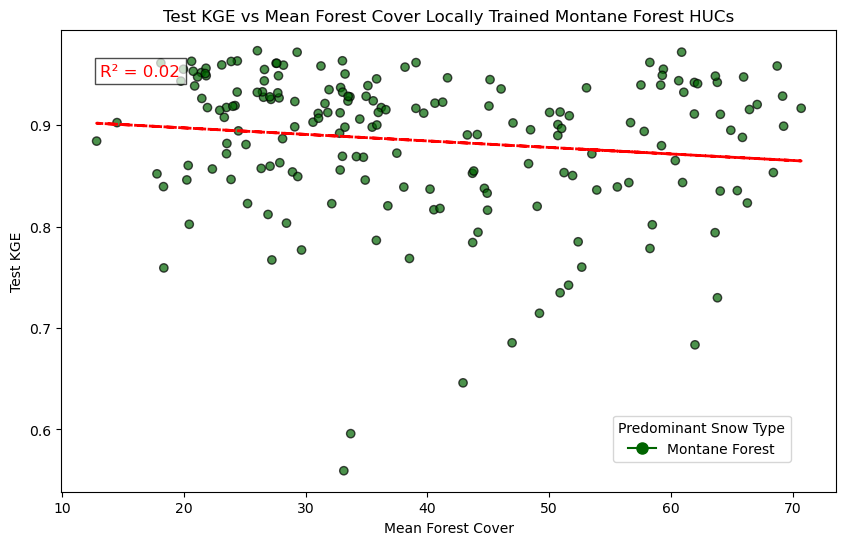

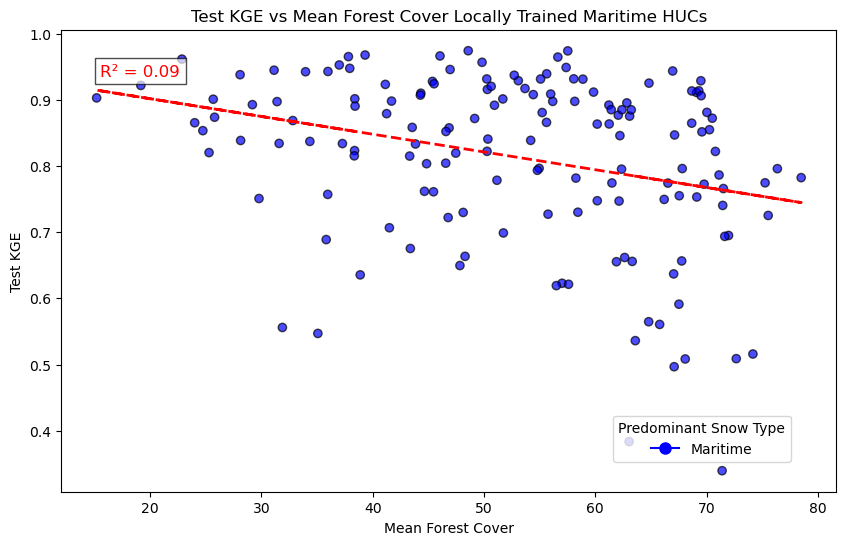

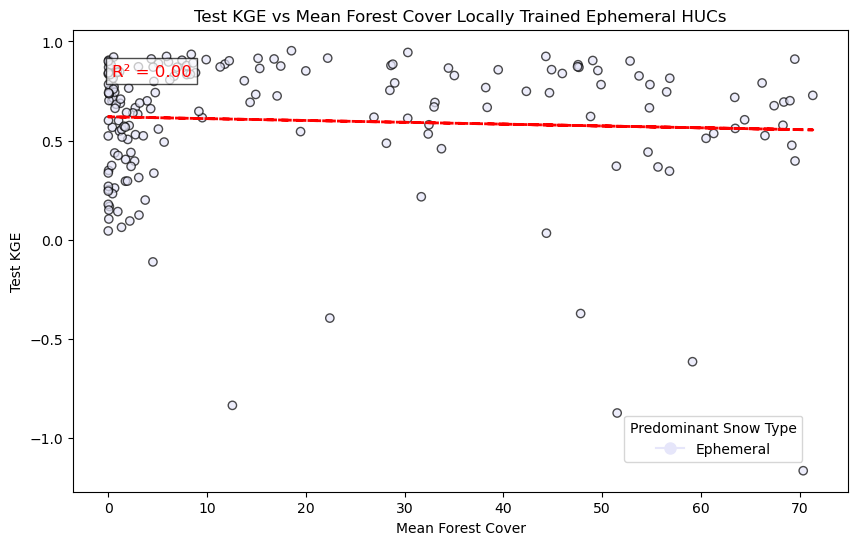

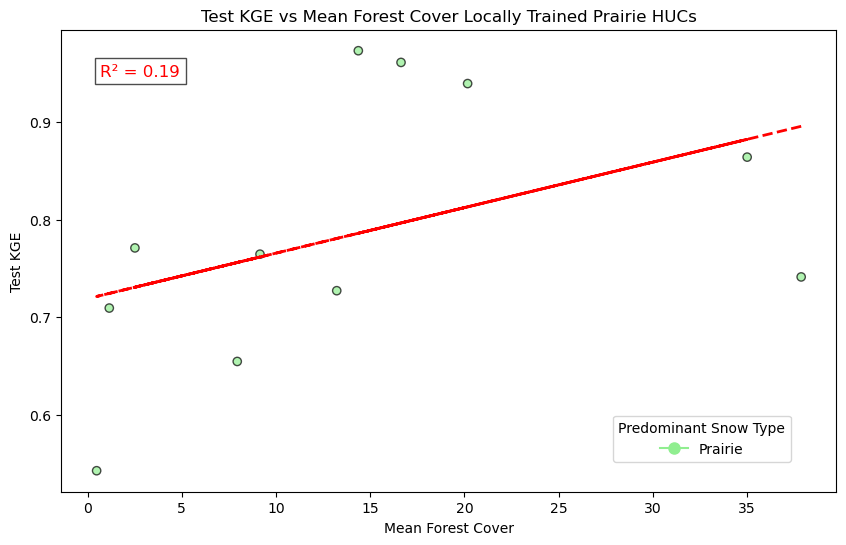

In [32]:
for snow_type in ["Montane Forest", "Maritime", "Ephemeral", "Prairie"]: 
    ttl = f"{y_var_name}_vs_{x_var_name}_Locally_Trained_{snow_type}_HUCs"
    color_map = extract_subdict(color_map_snow, [snow_type])
    single_snow_df = df_metrics[df_metrics["Predominant_Snow"] == snow_type]
    vu.plot_scatter_w_R2(single_snow_df, x_var_name, y_var_name, color_map, title = ttl)

# Step 7 Examine by Elevation 

In [ ]:
filtered_df.head(2)

In [ ]:
x_var_name = "mean_elevation"
y_var_name = "Test KGE"
ttl = f"{y_var_name}_vs_{x_var_name}_Locally Trained HUcs"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime"])
vu.plot_scatter(filtered_df_MandM, x_var_name, y_var_name, color_map, title = ttl)

In [ ]:
x_var_name = "mean_elevation"
y_var_name = "Test KGE"
color_map = extract_subdict(color_map_snow, ["Montane Forest", "Maritime", "Ephemeral"])
ttl = f"{y_var_name}_vs_{x_var_name}_Locally Trained HUCs"
vu.plot_scatter(filtered_df, x_var_name, y_var_name, color_map, title = ttl)

In [ ]:
# Count occurrences of each elevation category
elevation_counts = filtered_df['Elevation Category'].value_counts()

# Print the counts
print(elevation_counts)
print(np.sum(elevation_counts))

In [ ]:
#parameter = "Test KGE"
#groupby ="Elevation Category"
#ttl = f"Boxplot of {parameter} by {groupby} - Locally Trained Sub-Watersheds (Includes Ephemeral Sub-Watersheds)"
#color_map = {"low": "blue", "lower mid": "green", "mid": "yellow", "upper mid": "#C2B280", "high": "#A52A2A"}
#plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = groupby, color_map = color_map)

In [ ]:
#parameter = "Test MSE"
#groupby ="Elevation Category"
#ttl = f"Boxplot of {parameter} by {groupby} - Locally Trained Sub-Watersheds (Includes Ephemeral Sub-Watersheds)"
#color_map = {"low": "blue", "lower mid": "green", "mid": "yellow", "upper mid": "#C2B280", "high": "#A52A2A"}
#plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = groupby, color_map = color_map)